In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/6r/r5dfhtxd75g2p4pkybxl8jcc0000gn/T/ipykernel_446/1205883626.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/"
# train/val/test dir CHANGE TO 64 or 255
data_file_path = data_dir + "/preprocessed_data/train_64_noreroofs.npy"
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "/preprocessed_data/val_64_noreroofs.npy"

In [3]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [4]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)


Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [5]:
sample = data[0]  # get a sample from the dataset
print(type(sample))
print(len(sample))  # check the length of the tuple
print(sample[0])  # check the shape of the image tensor

<class 'tuple'>
3
tensor([[[0.5451, 0.4941, 0.4588,  ..., 0.0627, 0.1922, 0.2784],
         [0.6157, 0.6157, 0.5686,  ..., 0.0745, 0.0745, 0.2627],
         [0.5725, 0.6157, 0.6196,  ..., 0.0941, 0.1137, 0.1725],
         ...,
         [0.0157, 0.0078, 0.0118,  ..., 0.1098, 0.2275, 0.2431],
         [0.1529, 0.1882, 0.1686,  ..., 0.1529, 0.2196, 0.2431],
         [0.5686, 0.5725, 0.5490,  ..., 0.1294, 0.1333, 0.0863]],

        [[0.5686, 0.5255, 0.5020,  ..., 0.0353, 0.1804, 0.3137],
         [0.6314, 0.6431, 0.6078,  ..., 0.0392, 0.0353, 0.2745],
         [0.6039, 0.6392, 0.6235,  ..., 0.0471, 0.0627, 0.1412],
         ...,
         [0.0157, 0.0157, 0.0275,  ..., 0.1020, 0.2118, 0.2196],
         [0.1529, 0.1882, 0.1843,  ..., 0.1529, 0.1961, 0.2196],
         [0.5843, 0.5804, 0.5529,  ..., 0.1216, 0.1216, 0.0784]],

        [[0.5451, 0.4941, 0.4588,  ..., 0.0235, 0.1373, 0.2196],
         [0.6118, 0.6157, 0.5647,  ..., 0.0275, 0.0118, 0.1882],
         [0.5490, 0.5961, 0.5843,  ..., 

In [6]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
print(fixed_x.shape)
# torch.Size([32, 3, 255, 255]) or torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])


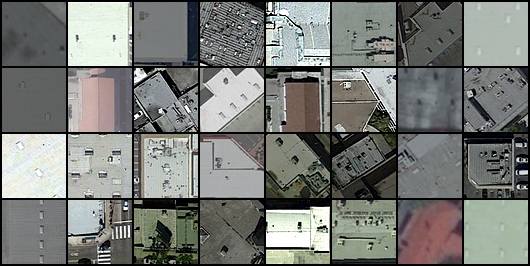

In [7]:
# can be skipped?
# Check to see if data is loaded 
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [8]:
# Set default parameters
image_channels = fixed_x.size(1)

img_dim = fixed_x.size(-1)
print(img_dim)

64


In [9]:
from torch import device

def loss_fn(recon_x, x, mu, logvar,beta=1.0):
    x = x.to(device)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    KLD*=beta
    return BCE + KLD, BCE, KLD

In [10]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim = img_dim, image_channels=image_channels, z_dim=128,device=device).to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

# Train VAE

In [ ]:
# TRAIN VAE

filename = model_dir+'/roofnet_VAE_64_1.pth'
epochs = 50
bs=32
train = True


if train:

    start_time = time.time()  # record the start time

    epoch = 0
    while epoch < epochs:
        
        for idx in range(100):
            images = next(iter(dataloader))
            images = images[0]
            recon_images, z, mu, logvar = model(images.to(device))
            loss, bce, kld = loss_fn(recon_images, images, mu, logvar, beta=5.0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
        epoch += 1
        print(to_print)

        # save the model
    torch.save(model.state_dict(),  filename)
    end_time = time.time()  # record the end time
    training_time = end_time - start_time  # calculate the training time in seconds
    print("Training time: {:.2f} seconds".format(training_time))

In [15]:
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_VAE_64_bias_1.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1024, bias=True)
)

# Compare real image and reconstruction

Note: VAEs are known to generate blurry. The reason is that the latent code is trying to compress as much info as possible and only focus on the meaningful features.

In [21]:
#64x64
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE

# change to the name of the model you want to load
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + '/roofnet_VAE_64_1.pth'))
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

In [18]:
#255x255
# JUST WORKING WITH 64x64 IMAGES 
model_dir_old = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models"
model = VAE(img_dim=255,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load((model_dir_old +'/roofnet_VAE_hard.pth'),  map_location=torch.device('cpu')))
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "encoder.8.weight", "encoder.8.bias", "encoder.10.weight", "encoder.10.bias", "decoder.9.weight", "decoder.9.bias", "decoder.11.weight", "decoder.11.bias". 
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([32, 3, 4, 4]) from checkpoint, the shape in current model is torch.Size([8, 3, 3, 3]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([64, 32, 4, 4]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([128, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3]).
	size mismatch for encoder.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.6.weight: copying a param with shape torch.Size([256, 128, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 32, 4, 4]).
	size mismatch for encoder.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.5.weight: copying a param with shape torch.Size([64, 32, 6, 6]) from checkpoint, the shape in current model is torch.Size([64, 32, 5, 5]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([32, 3, 6, 6]) from checkpoint, the shape in current model is torch.Size([32, 16, 5, 5]).
	size mismatch for decoder.7.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([16]).

In [22]:
# compare original and reconstructed images
def compare(x):
    x=x.to(device)
    recon_x,_, _, _ = model(x)
    return torch.cat([x, recon_x])

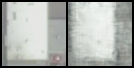

In [24]:
fixed_x = next(iter(dataloader))[0][:1]
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

# Use validation data to make predicitons

In [25]:
transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
val_data = ImageDataset(val_data_file_path,
                    transform=transform_chain)

Loading data
Done loading data
Length 175
Num Roofs 25


In [26]:
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=7, shuffle=False)
val_dataloader = iter(val_dataloader)

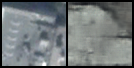

In [27]:
fixed_x = next(iter(val_dataloader))[0][:1]
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [28]:
out = []
latents = []
meta = []
for i in val_dataloader:
    images = i[0]
    recon_images,z, _, _ = model(images.to(device))
    z = z.detach().cpu().numpy()
    latents.append(z)
    meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])
    d = int(np.argmax([np.linalg.norm(zi-zj) for zi,zj in zip(z[1:],z[:-1])]))+2013
    out.append([i[2]['address'][0],d,int(i[2]['transition_year'][0].cpu().numpy())])
out = np.array(out)
latents = np.array(latents)

In [29]:
hold = 0
l = 0
for i in out:
    if i[2] != 0:
        l += 1
        if i[1]==i[2]:
            hold += 1
print(hold/l)

0.3333333333333333


Looking at just the argmax of distance between latents does not produce a great accuracy. There are clearly many images where the largest distance between latents is a terrible metric for reroof. The verticle bar represents the reroof date, if it is missing there is no reroof.

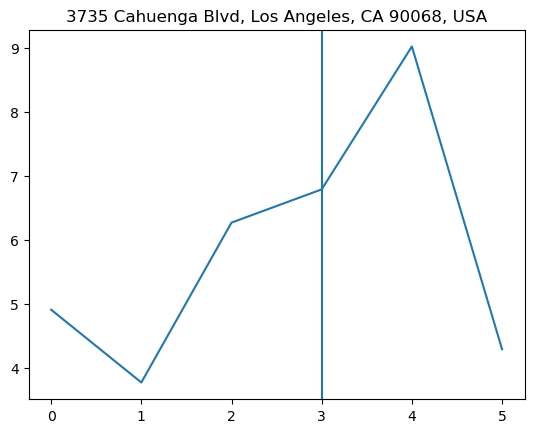

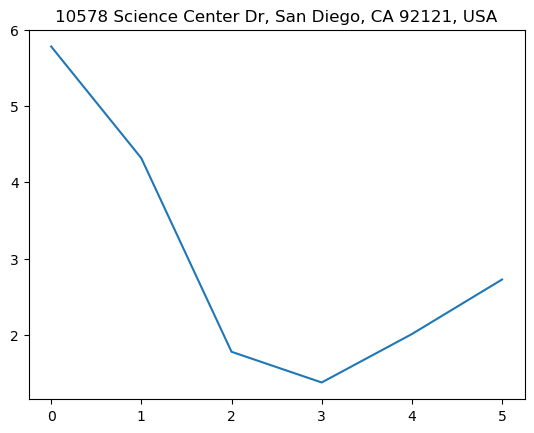

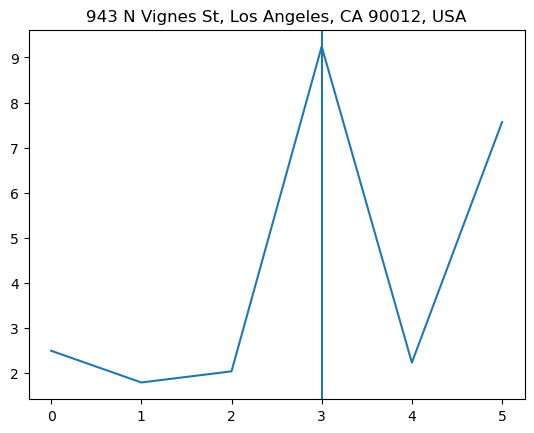

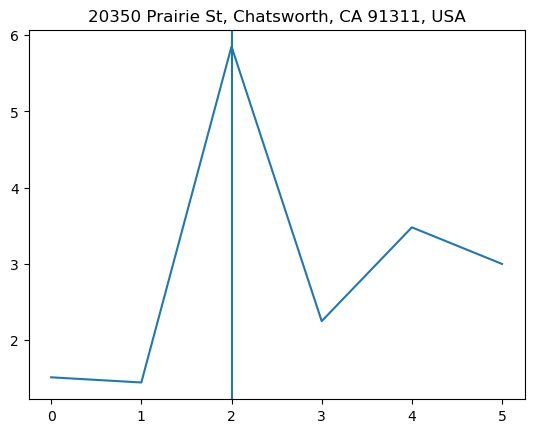

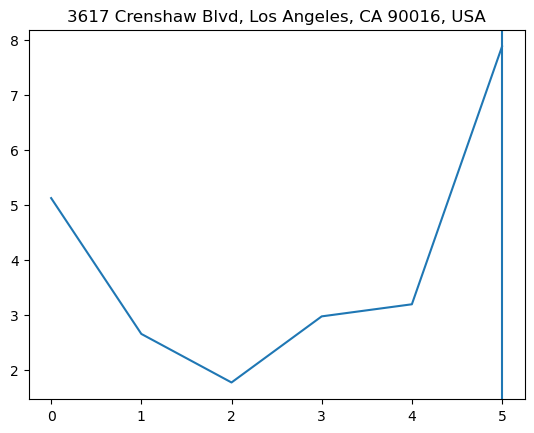

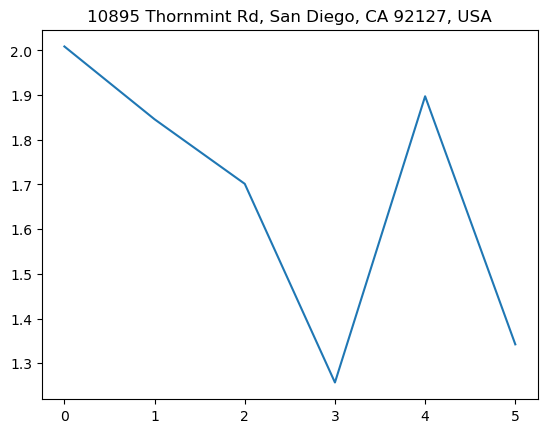

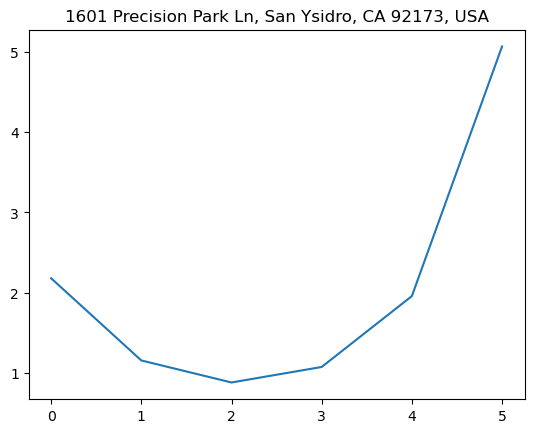

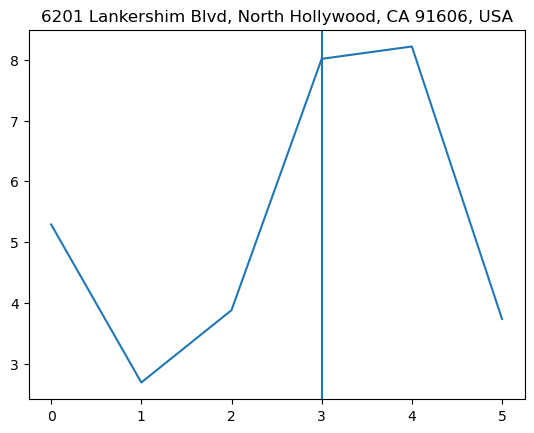

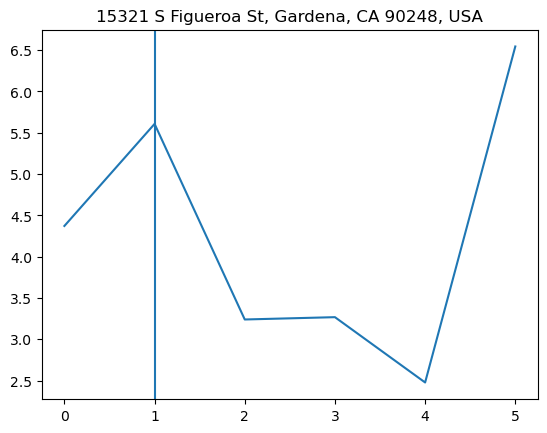

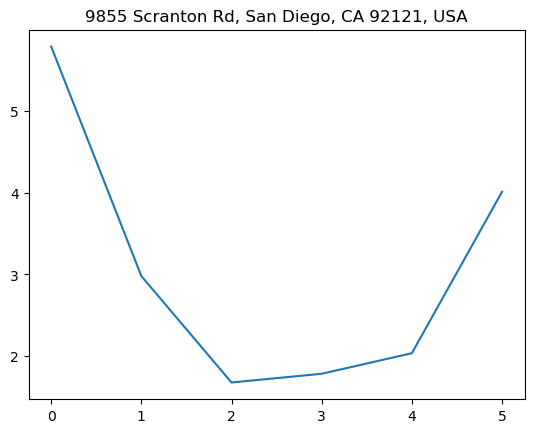

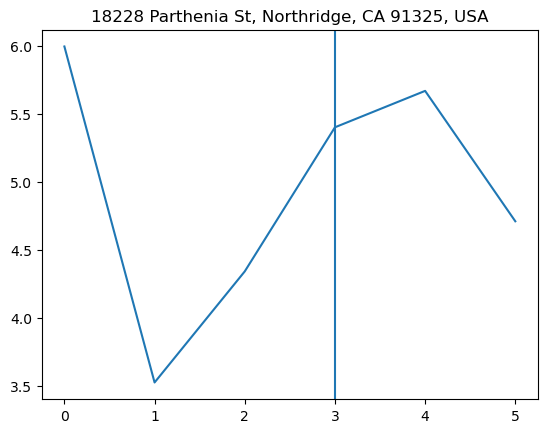

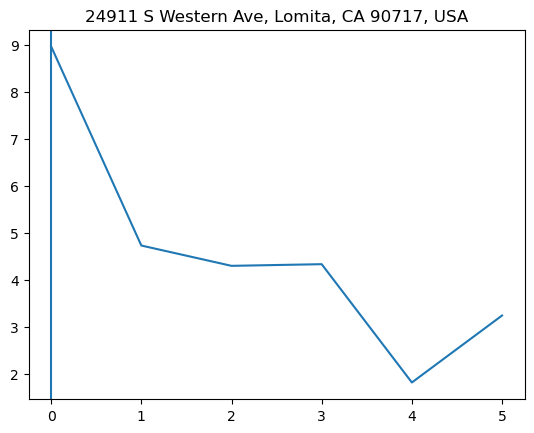

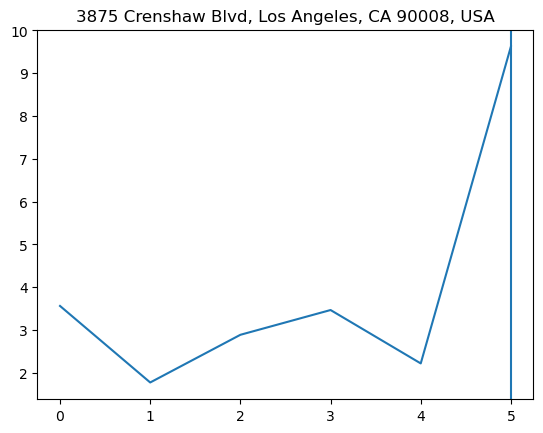

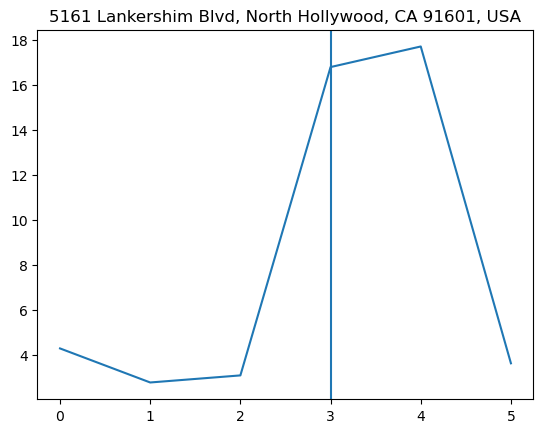

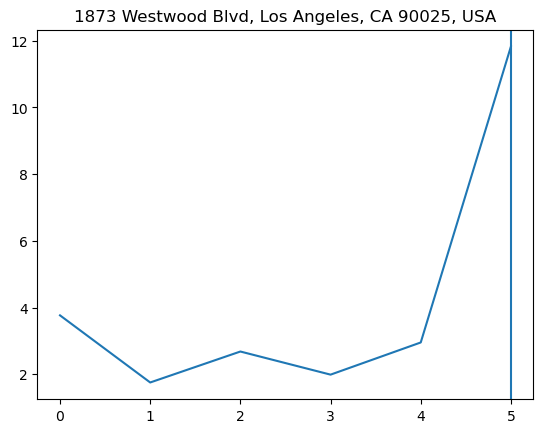

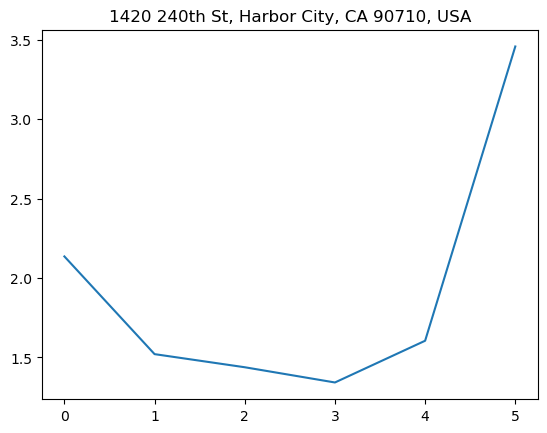

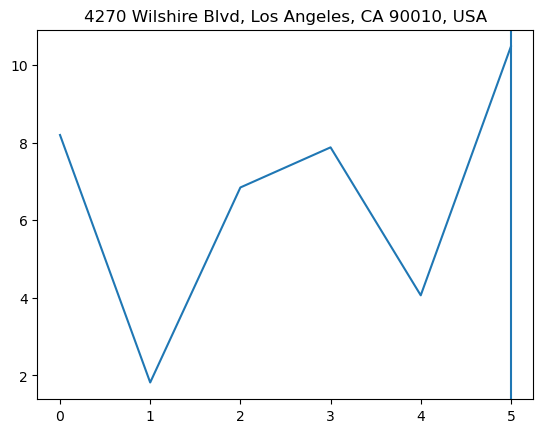

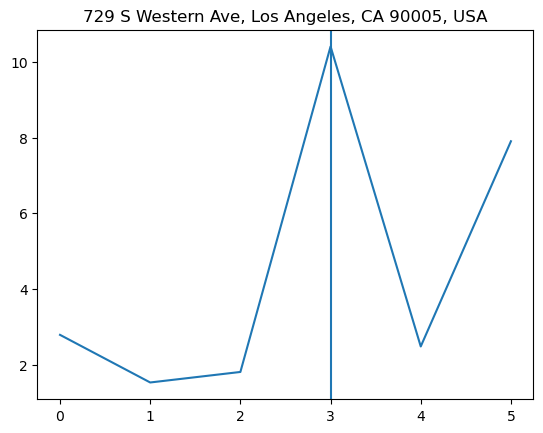

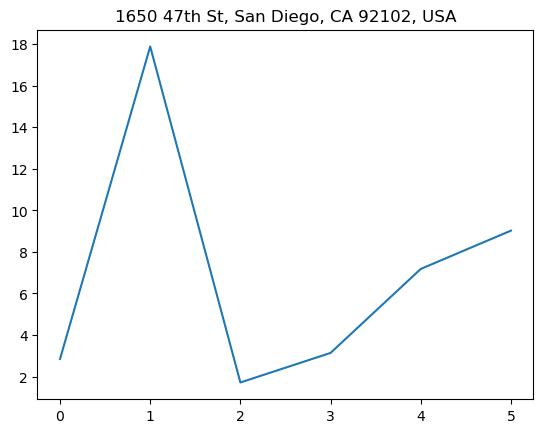

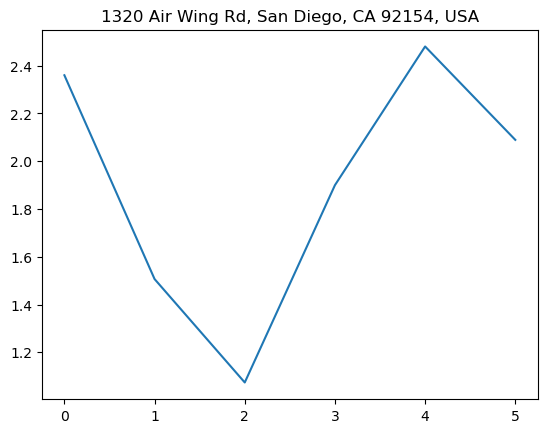

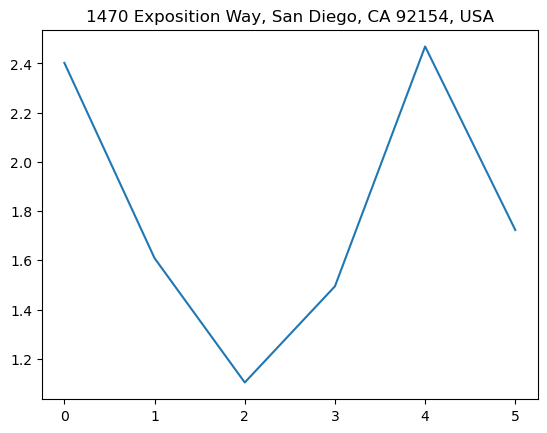

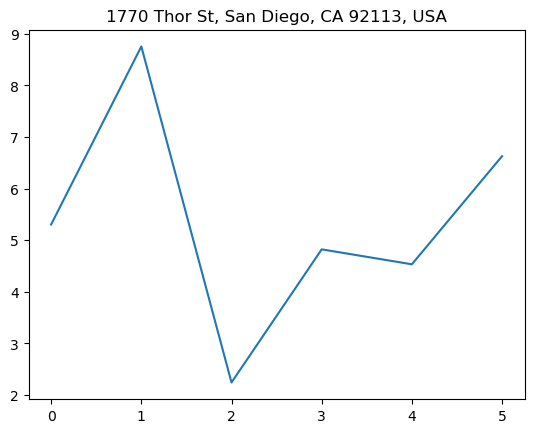

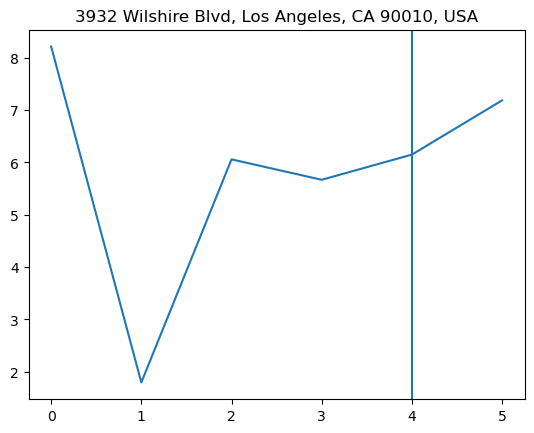

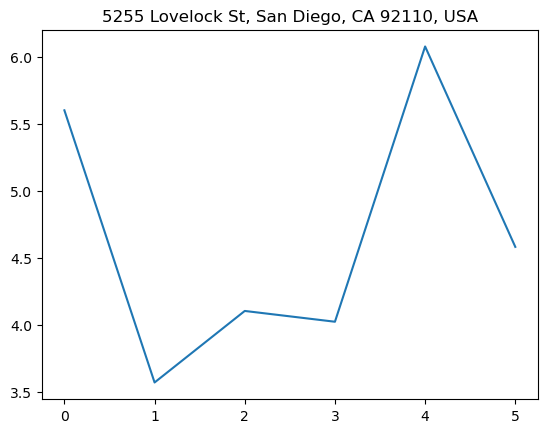

In [30]:
for j in range(len(latents)):
    diff = []
    for i in range(6):
        diff.append(np.linalg.norm(latents[j][i]-latents[j][i+1]))
    plt.plot(diff)
    plt.title(meta[j][0])
    if meta[j][1] != 0:
        plt.axvline(int(meta[j][1])-2013)
    plt.show()

# Build binary classifier on latents

In [31]:
from torch.autograd import Variable

## Helper functions:

In [32]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
# classifying two images as reroof if the probability is greater than the threshold

def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):    # model is the classification model
    v_1 = np.hstack((latent_1,latent_2)) # concatenate the two latent vectors
    v_2 = np.hstack((latent_2,latent_1)) # concatenate the two latent vectors
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
    p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
    prob = max([p_1.item(),p_2.item()]) # take the max probability
    return prob >= prob_threshold # return 1 if the probability is greater than the threshold, 0 otherwise

In [33]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
# If no transition detected, returns 0
def gen_predictions(latents,meta,model,prob_threshold=0.5): 
    out = [] 
    for i in range(len(latents)): # for each building
        hold = [] # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0])) # append the address
        trans_year = 0 # initialize the transition year
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold): # if the pair is classified as a reroof
                trans_year = j + 2013   # set the transition year to the year of the pair
                break
        hold.append(trans_year)  # append the transition year
        hold.append(int(meta[i][1])) # append the actual transition year
        out.append(hold) # append the list to the output
    return np.array(out) # return the output as an array

In [34]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
# If no transition detected, returns 0
def get_max_prob(latents,meta,model,prob_threshold=0.5): 
    out = []
    for i in range(len(latents)): # for each building
        hold = []  # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0]))   # append the address
        trans_year = 0
        temp = [] # hold the probabilities
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            latent_1 = latents[i][j] # get the latent vectors
            latent_2 = latents[i][j+1] # get the latent vectors
            v_1 = np.hstack((latent_1,latent_2)) # concatenate the latent vectors
            v_2 = np.hstack((latent_2,latent_1)) # concatenate the latent vectors
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
            p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
            prob = max([p_1.item(),p_2.item()]) # take the max probability
            temp.append(prob) # append the probability
        index = np.argmax(temp)     # get the index of the max probability
        if temp[index]>=prob_threshold: # if the max probability is greater than the threshold
            trans_year = 2013 + index # set the transition year to the year of the max probability 
        hold.append(trans_year) # append the transition year
        hold.append(int(meta[i][1]))       # append the actual transition year
        out.append(hold)    # append the list to the output
    return np.array(out)    # return the output as an array

In [35]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
# No reroof is defined as a building that has no reroof in the dataset
# Reroof is defined as a building that has a reroof in the dataset
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):   
    no_reroof_pred = [] # hold the predictions for buildings with no reroof
    reroof_pred = [] # hold the predictions for buildings with a reroof
    hold = acc_metric(latents,meta, net ,threshold) # get the predictions
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2]))) # print the overall accuracy
    for i in hold: # for each building
        if int(i[2])==0:    # if the building has no reroof
            no_reroof_pred.append(int(int(i[1]) == 0))      # append the prediction
        else:
            reroof_pred.append(int(i[1]==i[2]))         # append the prediction
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [36]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):     
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [37]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
# Generates latents for all buildings in dataloader

def gen_latents(dataloader, model): # generate latents for all buildings in dataloader
    latents = [] # hold the latents for the buildings
    meta = [] # hold the meta data for the buildings
    for i in dataloader: # for each building
        images = i[0] # get the images
        _, z, _, _ = model(images.to(device)) # get the latents
        z = z.detach().cpu().numpy()    # detach the latents in order to append to list
        latents.append(z)  # append the latents
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])     # append the meta data
    latents = np.array(latents)     # convert the latents to an array
    return latents, meta    

In [38]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
# Generates all possible pairs of latent images and their label 1:reroof, 0:no reroof
# Used for training binary classifier

def gen_binary_data(latents, meta):         # generate all possible pairs of latent images and their label 1:reroof, 0:no reroof
    data_hold = []  # hold the latent pairs
    label_hold = []     # hold the labels
    for i in range(len(latents)):   # for each building
        for j in range(len(latents[i])):    # for each latent vector
            for k in range(len(latents[i])):        # for each latent vector
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))      # append the latent pair
                year_j = 2012+j < meta[i][1]        # get the year of the latent vector
                year_k = 2012+k < meta[i][1]        # get the year of the latent vector
                label_hold.append(float(year_j != year_k))    # append the label
    data_hold = np.array(data_hold)     # convert the data to an array
    label_hold = np.array(label_hold)   # convery the labels to an array
    
    return data_hold, label_hold

In [39]:
# train_epoch for binary classifier

def binary_train_epoch(model, opt, criterion, data, labels, data_loader, val_data, val_labels, val_data_loader, best_acc, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
    
    model.train() # set model to training mode
    loss_hold = [] # hold loss for each batch
    
    for i in iter(data_loader): # iterate through batches
        batch_size = len(i)   # get batch size
        x_batch = data[i]   # get batch data 
        y_batch = labels[i]    # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch)) # convert to torch variable
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)       # convert to torch variable
        y_batch = y_batch.view(batch_size,-1)       # reshape to batch size
        
        opt.zero_grad()         # zero the parameter gradients
        y_hat = model(x_batch.to(model.device))         # forward pass, after the data is on the correct device, it is passed through the model
        loss = criterion(y_hat,y_batch)     # calculate loss 
        loss.backward()         # backward pass
        opt.step()          # update parameters
        
        loss_hold.append(loss.item()/batch_size)            # append loss
    print("Epoch training loss:{:.3f}".format(np.mean(loss_hold)))   # print epoch loss
    
    #validate  

    model.eval()
    pred_acc = [] # hold prediction accuracy for each batch
    for i in iter(val_data_loader):     # iterate through batches
        batch_size = len(i)     # get batch size
        x_batch = val_data[i]       # get batch data
        y_batch = val_labels[i]     # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch))   # convert to torch variable
        
        if logit:   # if logit, use sigmoid
            y_logits = model(x_batch.to(model.device))       # forward pass
            s = nn.Sigmoid()    # sigmoid function
            y_hat = s(y_logits) > 0.5     # get prediction
        else:
            y_hat = model(x_batch.to(model.device))>0.5     # forward pass, get prediction
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1))) # append prediction accuracy
        
    pred_acc = np.mean(pred_acc)    # get epoch prediction accuracy
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))        # print epoch prediction accuracy
    
    if pred_acc >= best_acc:        # if epoch prediction accuracy is better than best prediction accuracy
        best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
        best_acc = pred_acc     # update best prediction accuracy
    
    net.load_state_dict(best_model_wts)     # load best model weights
    
    return net, best_acc 
        
        

## Load the data

In [40]:
# z_dim = 128 is the dimension of the latent space
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + 'roofnet_VAE_64_1.pth'))
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs_bias.npy"

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [41]:
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [42]:
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [43]:
latents, meta = gen_latents(binary_dataloader, model)
print(latents.shape)

(150, 7, 128)


In [44]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)
print(val_latents.shape)

(25, 7, 128)


In [45]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)

In [90]:
data_hold, label_hold = gen_binary_data(latents, meta)
len(data_hold)
print(data_hold.shape)
print(data_hold)
print(label_hold)

(7350, 256)
[[ 0.14911543  0.9243549  -0.03423963 ... -0.23209862  0.76787126
   0.13397543]
 [ 0.14911543  0.9243549  -0.03423963 ... -0.31781963  0.63637817
   0.1457871 ]
 [ 0.14911543  0.9243549  -0.03423963 ... -0.32071966  0.85823876
   0.17351665]
 ...
 [ 0.37727907  0.20284821 -0.5428362  ... -0.12754683 -1.815669
   0.63927597]
 [ 0.37727907  0.20284821 -0.5428362  ... -0.09157399 -1.3415076
   0.60143656]
 [ 0.37727907  0.20284821 -0.5428362  ... -0.09242082 -1.4772174
   0.64057523]]
[0. 0. 0. ... 0. 0. 0.]


In [47]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)
print(val_hold.shape)

(1225, 256)


In [48]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)
print(test_hold.shape)


(2695, 256)


In [49]:
# to check the number of reroofs and no reroofs in the dataset
# it is because we have 7 images for builidings and if there is a reroof, the count of reroofs will be smaller
reroof_count = np.sum(label_hold == 1)
no_reroof_count = np.sum(label_hold == 0)

print(f"Reroof count: {reroof_count}")
print(f"No Reroof count: {no_reroof_count}")


Reroof count: 1828
No Reroof count: 5522


## Define the model

In [50]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



In [51]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True) # index loader is used to shuffle the data
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

## Train the model:

In [139]:
num_epochs = 10
best_acc = 0
for e in range(num_epochs):
    print('Running epoch {}/{}'.format(e,num_epochs))
    net, best_acc = binary_train_epoch(net, opt, criterion, data_hold, label_hold, index_loader, val_hold, val_label, val_index_loader, best_acc)

Running epoch 0/10


KeyboardInterrupt: 

In [64]:
# Earliest transition method prediction:
# if i dont train model before, these metrics will be small and not useful
hold = gen_metrics(gen_predictions, val_latents, val_meta, net)

Overall accuracy: 0.840
No reroof prediction accuracy: 0.900
Reroof prediction accuracy: 0.800


In [65]:
#model_dir_old = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models/"
#net.load_state_dict(torch.load((model_dir_old + 'roofnet_binary_class_easy_easyval.pth'), map_location=torch.device('cpu')))


In [66]:
# save model which can be used for prediction
torch.save(net.state_dict(), model_dir + '/roofnet_binary_class_1.pth') 

## XAI SHAP Try


In [269]:
model = Net()  # Instantiate your model
model.load_state_dict(torch.load(model_dir + '/roofnet_binary_class_1.pth'))

<All keys matched successfully>

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

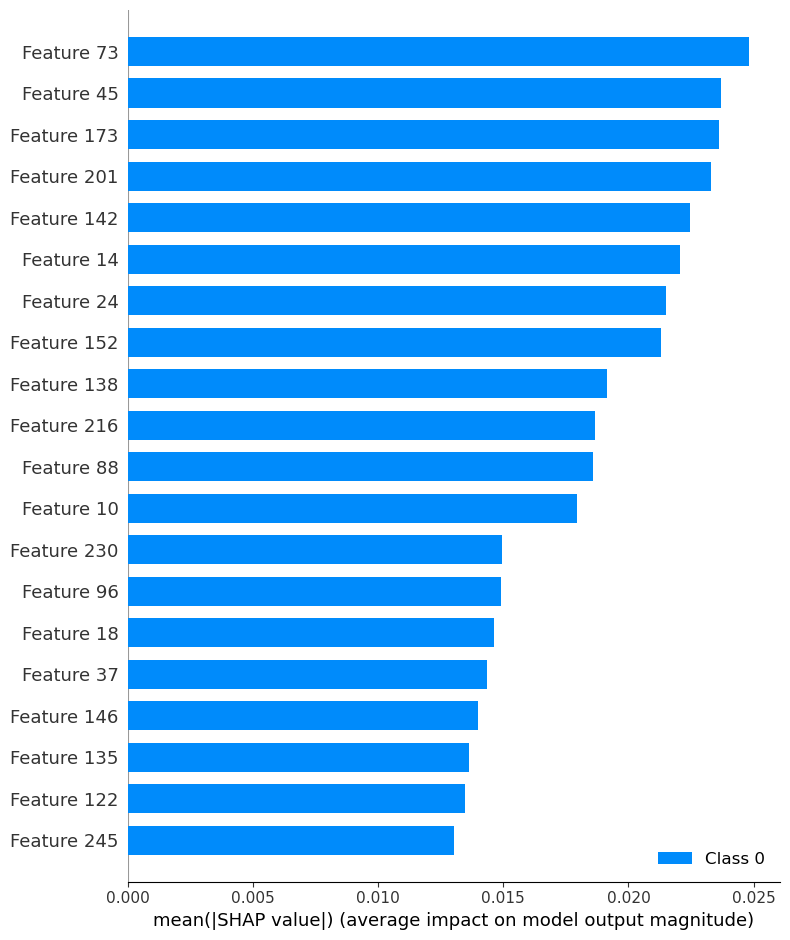

In [270]:
import shap
import torch
import numpy as np

# Assuming your model is defined somewhere above
# Making sure the model is in evaluation mode
model.eval()

# Define device (use CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# I'm assuming the gen_binary_data function and its parameters are defined elsewhere
data_hold, label_hold = gen_binary_data(latents, meta)

# Convert your data to float32 type if it's not already
data_hold = data_hold.astype(np.float32)

def batch_predict(data):
    """ Feed the data in batches to the model for prediction """
    data = torch.from_numpy(data).float().to(device)
    with torch.no_grad():  # Disable gradient calculations for speedup and memory saving
        outputs = model(data)
    return outputs.detach().cpu().numpy()

# Split your data into background and test datasets directly
background_data = data_hold[:200]  # For example, use 500 data points as background data
test_data = data_hold[200:400]  # Use another set of 500 data points as test data

# Initialize the KernelExplainer with the batch prediction function and background data
explainer = shap.KernelExplainer(batch_predict, background_data)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(test_data)

# Visualize the SHAP values using a summary plot
shap.summary_plot(shap_values, test_data)


In [271]:
shap_values_tensor = torch.tensor(shap_values)
mean_abs_shap_values = torch.mean(torch.abs(shap_values_tensor), axis=1)
print(mean_abs_shap_values)

tensor([[0.0035, 0.0043, 0.0040, 0.0042, 0.0036, 0.0060, 0.0052, 0.0087, 0.0043,
         0.0110, 0.0179, 0.0053, 0.0042, 0.0071, 0.0221, 0.0069, 0.0029, 0.0062,
         0.0146, 0.0052, 0.0047, 0.0041, 0.0092, 0.0049, 0.0215, 0.0031, 0.0049,
         0.0056, 0.0037, 0.0031, 0.0069, 0.0061, 0.0028, 0.0042, 0.0062, 0.0034,
         0.0034, 0.0144, 0.0032, 0.0042, 0.0030, 0.0064, 0.0061, 0.0038, 0.0030,
         0.0237, 0.0041, 0.0031, 0.0040, 0.0056, 0.0050, 0.0036, 0.0034, 0.0028,
         0.0053, 0.0036, 0.0031, 0.0057, 0.0089, 0.0048, 0.0047, 0.0033, 0.0035,
         0.0048, 0.0032, 0.0035, 0.0066, 0.0106, 0.0049, 0.0046, 0.0031, 0.0066,
         0.0026, 0.0248, 0.0050, 0.0068, 0.0031, 0.0028, 0.0031, 0.0036, 0.0036,
         0.0034, 0.0039, 0.0045, 0.0082, 0.0125, 0.0053, 0.0054, 0.0186, 0.0072,
         0.0032, 0.0069, 0.0078, 0.0028, 0.0045, 0.0047, 0.0149, 0.0087, 0.0033,
         0.0086, 0.0108, 0.0036, 0.0108, 0.0039, 0.0096, 0.0031, 0.0130, 0.0030,
         0.0037, 0.0054, 0.0

In [272]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



In [296]:
# train_epoch for binary classifier

def binary_train_epoch(model, opt, criterion, data, labels, data_loader, val_data, val_labels, val_data_loader, best_acc, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
    
    model.train() # set model to training mode
    loss_hold = [] # hold loss for each batch
    
    for i in iter(data_loader): # iterate through batches
        batch_size = len(i)   # get batch size
        x_batch = data[i]   # get batch data 
        y_batch = labels[i]    # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch)) # convert to torch variable
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)       # convert to torch variable
        y_batch = y_batch.view(batch_size,-1)       # reshape to batch size
        
        opt.zero_grad()         # zero the parameter gradients
        y_hat = model(x_batch.to(model.device))         # forward pass, after the data is on the correct device, it is passed through the model
        loss = criterion(y_hat,y_batch)     # calculate loss 
        # Convert shap_values to a tensor
        # shap_values_tensor = torch.tensor(shap_values)
        lam = 0.5
        regularization_term = lam * torch.sum(mean_abs_shap_values)

        
        # Calculate the SHAP loss
        # shap_loss = lam * torch.norm(shap_values_tensor, p=1)

        # Calculate the total loss
        loss = loss + regularization_term
        loss.backward()         # backward pass
        opt.step()          # update parameters
        
        loss_hold.append(loss.item()/batch_size)            # append loss
    print("Epoch training loss:{:.3f}".format(np.mean(loss_hold)))   # print epoch loss
    
    #validate  

    model.eval()
    pred_acc = [] # hold prediction accuracy for each batch
    for i in iter(val_data_loader):     # iterate through batches
        batch_size = len(i)     # get batch size
        x_batch = val_data[i]       # get batch data
        y_batch = val_labels[i]     # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch))   # convert to torch variable
        
        if logit:   # if logit, use sigmoid
            y_logits = model(x_batch.to(model.device))       # forward pass
            s = nn.Sigmoid()    # sigmoid function
            y_hat = s(y_logits) > 0.5     # get prediction
        else:
            y_hat = model(x_batch.to(model.device))>0.5     # forward pass, get prediction
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1))) # append prediction accuracy
        
    pred_acc = np.mean(pred_acc)    # get epoch prediction accuracy
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))        # print epoch prediction accuracy
    
    if pred_acc >= best_acc:        # if epoch prediction accuracy is better than best prediction accuracy
        best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
        best_acc = pred_acc     # update best prediction accuracy
    
    net.load_state_dict(best_model_wts)     # load best model weights
    
    return net, best_acc 
        

In [297]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True) # index loader is used to shuffle the data
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

In [298]:
num_epochs = 10
best_acc = 0
for e in range(num_epochs):
    print('Running epoch {}/{}'.format(e,num_epochs))
    net, best_acc = binary_train_epoch(net, opt, criterion, data_hold, label_hold, index_loader, val_hold, val_label, val_index_loader, best_acc)

Running epoch 0/10
Epoch training loss:0.028
Epoch validation accuracy: 0.909%
Running epoch 1/10
Epoch training loss:0.027
Epoch validation accuracy: 0.904%
Running epoch 2/10
Epoch training loss:0.027
Epoch validation accuracy: 0.905%
Running epoch 3/10
Epoch training loss:0.027
Epoch validation accuracy: 0.907%
Running epoch 4/10
Epoch training loss:0.027
Epoch validation accuracy: 0.901%
Running epoch 5/10
Epoch training loss:0.027
Epoch validation accuracy: 0.907%
Running epoch 6/10
Epoch training loss:0.027
Epoch validation accuracy: 0.906%
Running epoch 7/10
Epoch training loss:0.027
Epoch validation accuracy: 0.903%
Running epoch 8/10
Epoch training loss:0.027
Epoch validation accuracy: 0.879%
Running epoch 9/10
Epoch training loss:0.027
Epoch validation accuracy: 0.905%


In [299]:
# save model which can be used for prediction
torch.save(net.state_dict(), model_dir + '/roofnet_binary_class_shap_2_05.pth') 

In [300]:
hold = gen_metrics(get_max_prob, val_latents, val_meta, net)

Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800


In [301]:
hold = gen_metrics(get_max_prob, test_latents, test_meta, net)

Overall accuracy: 0.745
No reroof prediction accuracy: 0.880
Reroof prediction accuracy: 0.633


In [279]:
out = {'site_address': hold[:,0], 'transition_true': hold[:,2], 'transition_predicted': hold[:,1]}

In [289]:
import pandas as pd
# to save the predictions
pd.DataFrame(out).to_csv('Argmax(Prob) Shap2Back0802.csv')

## SHAP Values used for the Shap1 Model

In [ ]:
import torch
import numpy as np


# Making sure the model is in evaluation mode
model.eval()

# Define device (use CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your input and labels (which you have already defined)
data_hold, label_hold = gen_binary_data(latents, meta)

# Convert your data to float32 type if it's not already
data_hold = data_hold.astype(np.float32)


def batch_predict(data):
    data = torch.from_numpy(data).float().to(device)
    with torch.no_grad():  # Disable gradient calculations for speedup and memory saving
        outputs = model(data)
    return outputs.detach().cpu().numpy()

# Split your data into background and test datasets
background_data_np = data_hold[:500]  # Use 500 data points as background data
test_data_np = data_hold[500:1000]  # Use 500 data points as test data


# Initialize the KernelExplainer
explainer = shap.KernelExplainer(batch_predict, background_data_np)

# Compute SHAP values
shap_values = explainer.shap_values(test_data_np)

# Visualization
shap.summary_plot(shap_values, test_data_np)

In [ ]:
shap_values_tensor = torch.tensor(shap_values)
mean_abs_shap_values = torch.mean(torch.abs(shap_values_tensor), axis=1)
print(mean_abs_shap_values)

In [50]:
# was not used for shap 1
import shap

# taking numpy array input, converting it to a tensor, passing it through the network, and then converting the output back to a numpy array
# the SHAP library works with numpy arrays, not tensors


def batch_predict(data):
    # convert the input to a PyTorch tensor
    data = torch.from_numpy(data).float().to(device)

    # get the model output
    outputs = model(data)

    # Convert the output back to a numpy array
    return outputs.detach().cpu().numpy()

# convert your background data to a numpy array
# The sum of the SHAP values equals the difference 
# between the expected model output (averaged over the background dataset) and the current model output
# https://distill.pub/2020/attribution-baselines/ 
# change the background data to all the data or more points later, data_hold is our train data
# because this would be a baseline case 
background_data_np = data_hold[:100] # use 100 data points (pair of images) as background data
test_data_np = data_hold[100:200] # use 100 data points as test data for which shap values are computed

# we use KernelExplainer for models that are not tree-based
explainer = shap.KernelExplainer(batch_predict, background_data_np)

# compute SHAP values
shap_values = explainer.shap_values(test_data_np)

# # convert the SHAP values and test data to float64
shap_values_float64 = np.array(shap_values, dtype=np.float64)
test_data_float64 = np.array(test_data_np, dtype=np.float64)

# visualize the SHAP values for the first test data instance

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_float64[0], test_data_float64[0], link="logit")

# https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

  0%|          | 0/100 [00:00<?, ?it/s]

In [131]:
# was not used for shap 1
shap_values = np.array(shap_values)

# Set the threshold
threshold = 0.01

# Identify the important features based on the threshold
important_features = []
for feature_idx, shap_vals in enumerate(shap_values.T):
    if np.abs(shap_vals).mean() > threshold:
        important_features.append(feature_idx)

# Print the indices of the important features
print("Important feature indices:", important_features)

Important feature indices: [10, 14, 24, 45, 73, 88, 100, 102, 117, 138, 142, 146, 152, 173, 201, 213, 216, 220, 228, 230, 234, 245]


## Train the model with an explainability term:

In [87]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



In [88]:
# train_epoch for binary classifier

def binary_train_epoch(model, opt, criterion, data, labels, data_loader, val_data, val_labels, val_data_loader, best_acc, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
    
    model.train() # set model to training mode
    loss_hold = [] # hold loss for each batch
    
    for i in iter(data_loader): # iterate through batches
        batch_size = len(i)   # get batch size
        x_batch = data[i]   # get batch data 
        y_batch = labels[i]    # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch)) # convert to torch variable
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)       # convert to torch variable
        y_batch = y_batch.view(batch_size,-1)       # reshape to batch size
        
        opt.zero_grad()         # zero the parameter gradients
        y_hat = model(x_batch.to(model.device))         # forward pass, after the data is on the correct device, it is passed through the model
        loss = criterion(y_hat,y_batch)     # calculate loss 
        # Convert shap_values to a tensor
        # shap_values_tensor = torch.tensor(shap_values)
        lam = 0.1
        regularization_term = lam * torch.sum(mean_abs_shap_values)

        
        # Calculate the SHAP loss
        # shap_loss = lam * torch.norm(shap_values_tensor, p=1)

        # Calculate the total loss
        loss = loss + regularization_term
        loss.backward()         # backward pass
        opt.step()          # update parameters
        
        loss_hold.append(loss.item()/batch_size)            # append loss
    print("Epoch training loss:{:.3f}".format(np.mean(loss_hold)))   # print epoch loss
    
    #validate  

    model.eval()
    pred_acc = [] # hold prediction accuracy for each batch
    for i in iter(val_data_loader):     # iterate through batches
        batch_size = len(i)     # get batch size
        x_batch = val_data[i]       # get batch data
        y_batch = val_labels[i]     # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch))   # convert to torch variable
        
        if logit:   # if logit, use sigmoid
            y_logits = model(x_batch.to(model.device))       # forward pass
            s = nn.Sigmoid()    # sigmoid function
            y_hat = s(y_logits) > 0.5     # get prediction
        else:
            y_hat = model(x_batch.to(model.device))>0.5     # forward pass, get prediction
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1))) # append prediction accuracy
        
    pred_acc = np.mean(pred_acc)    # get epoch prediction accuracy
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))        # print epoch prediction accuracy
    
    if pred_acc >= best_acc:        # if epoch prediction accuracy is better than best prediction accuracy
        best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
        best_acc = pred_acc     # update best prediction accuracy
    
    net.load_state_dict(best_model_wts)     # load best model weights
    
    return net, best_acc 
        
        

In [89]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True) # index loader is used to shuffle the data
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

In [90]:
num_epochs = 10
best_acc = 0
for e in range(num_epochs):
    print('Running epoch {}/{}'.format(e,num_epochs))
    net, best_acc = binary_train_epoch(net, opt, criterion, data_hold, label_hold, index_loader, val_hold, val_label, val_index_loader, best_acc)

Running epoch 0/10
Epoch training loss:0.025
Epoch validation accuracy: 0.866%
Running epoch 1/10
Epoch training loss:0.020
Epoch validation accuracy: 0.879%
Running epoch 2/10
Epoch training loss:0.019
Epoch validation accuracy: 0.892%
Running epoch 3/10
Epoch training loss:0.018
Epoch validation accuracy: 0.896%
Running epoch 4/10
Epoch training loss:0.017
Epoch validation accuracy: 0.886%
Running epoch 5/10
Epoch training loss:0.017
Epoch validation accuracy: 0.900%
Running epoch 6/10
Epoch training loss:0.017
Epoch validation accuracy: 0.898%
Running epoch 7/10
Epoch training loss:0.017
Epoch validation accuracy: 0.894%
Running epoch 8/10
Epoch training loss:0.017
Epoch validation accuracy: 0.903%
Running epoch 9/10
Epoch training loss:0.016
Epoch validation accuracy: 0.897%


In [ ]:
# save model which can be used for prediction
torch.save(net.state_dict(), model_dir + '/roofnet_binary_class_shap_1pth') 

In [91]:
hold = gen_metrics(get_max_prob, val_latents, val_meta, net)

Overall accuracy: 0.840
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.733


In [92]:
hold = gen_metrics(get_max_prob, test_latents, test_meta, net)

Overall accuracy: 0.782
No reroof prediction accuracy: 0.880
Reroof prediction accuracy: 0.700


## TRAIN IN THE BATCH

In [63]:
# Assuming your data shape is [batch_size, num_features]
import shap
num_features = data_hold.shape[1]
running_mean = torch.zeros(num_features).to(model.device)
running_variance = torch.zeros(num_features).to(model.device)
batch_count = 0


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## shap variance

In [75]:
# train_epoch for binary classifier
def binary_train_epoch(model, opt, criterion, data, labels, data_loader, val_data, val_labels, val_data_loader, best_acc, running_mean, running_variance, batch_count, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict())  # save best model weights
    model.train()  # set model to training mode
    loss_hold = []  # hold loss for each batch
    
    for i in iter(data_loader):  # iterate through batches
        batch_size = len(i)  # get batch size
        x_batch = data[i]  # get batch data 
        y_batch = labels[i]  # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch))  # convert to torch variable
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)  # convert to torch variable
        y_batch = y_batch.view(batch_size, -1)  # reshape to batch size
        
        opt.zero_grad()  # zero the parameter gradients
        y_hat = model(x_batch.to(model.device))
        loss = criterion(y_hat, y_batch)

        # calculate shap values for the current batch
        explainer = shap.DeepExplainer(model, x_batch.detach())
        shap_values = explainer.shap_values(x_batch.detach())
        
        # convert shap values to a tensor
        shap_values_tensor = torch.tensor(shap_values)

        # Update running mean and variance for SHAP values
        batch_mean = torch.mean(shap_values_tensor, dim=0)
        batch_variance = torch.var(shap_values_tensor, dim=0)
        
        batch_count += 1
        delta = batch_mean - running_mean
        running_mean += delta / batch_count
        delta2 = batch_mean - running_mean
        running_variance += delta * delta2

        # Regularization term based on variance
        lambda_reg = 0.5
        regularization_term = lambda_reg * torch.sum(running_variance / batch_count)

        # add regularization term to the loss
        total_loss = loss + regularization_term
        total_loss.backward()  # backward pass
        opt.step()  # update parameters
        
        loss_hold.append(total_loss.item() / batch_size)
    
    # [Rest of your validation and epoch end procedures remain unchanged]

    
    #validate  

    model.eval()
    pred_acc = [] # hold prediction accuracy for each batch
    for i in iter(val_data_loader):     # iterate through batches
        batch_size = len(i)     # get batch size
        x_batch = val_data[i]       # get batch data
        y_batch = val_labels[i]     # get batch labels
        
        x_batch = Variable(torch.from_numpy(x_batch))   # convert to torch variable
        
        if logit:   # if logit, use sigmoid
            y_logits = model(x_batch.to(model.device))       # forward pass
            s = nn.Sigmoid()    # sigmoid function
            y_hat = s(y_logits) > 0.5     # get prediction
        else:
            y_hat = model(x_batch.to(model.device))>0.5     # forward pass, get prediction
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1))) # append prediction accuracy
        
    pred_acc = np.mean(pred_acc)    # get epoch prediction accuracy
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))        # print epoch prediction accuracy
    
    if pred_acc >= best_acc:        # if epoch prediction accuracy is better than best prediction accuracy
        best_model_wts = copy.deepcopy(model.state_dict()) # save best model weights
        best_acc = pred_acc     # update best prediction accuracy
    
    net.load_state_dict(best_model_wts)     # load best model weights
    
    return net, best_acc, running_mean, running_variance, batch_count
        
        

In [76]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



In [77]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True) # index loader is used to shuffle the data
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

In [78]:
num_epochs = 10
best_acc = 0
for e in range(num_epochs):
    print('Running epoch {}/{}'.format(e,num_epochs))
    net, best_acc, running_mean, running_variance, batch_count = binary_train_epoch(net, opt, criterion, data_hold, label_hold, index_loader, val_hold, val_label, val_index_loader, best_acc, running_mean, running_variance, batch_count)


Running epoch 0/10


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Epoch validation accuracy: 0.854%
Running epoch 1/10
Epoch validation accuracy: 0.876%
Running epoch 2/10
Epoch validation accuracy: 0.870%
Running epoch 3/10
Epoch validation accuracy: 0.867%
Running epoch 4/10
Epoch validation accuracy: 0.882%
Running epoch 5/10
Epoch validation accuracy: 0.894%
Running epoch 6/10
Epoch validation accuracy: 0.885%
Running epoch 7/10
Epoch validation accuracy: 0.901%
Running epoch 8/10
Epoch validation accuracy: 0.902%
Running epoch 9/10
Epoch validation accuracy: 0.883%


In [79]:
# save model which can be used for prediction
torch.save(net.state_dict(), model_dir + '/roofnet_binary_class_shap_in_the_batch_var05.pth') 

In [80]:
# Earliest transition method prediction:
# if i dont train model before, these metrics will be small and not useful
hold = gen_metrics(gen_predictions, val_latents, val_meta, net)

Overall accuracy: 0.840
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.733


In [81]:
hold = gen_metrics(get_max_prob, val_latents, val_meta, net)

Overall accuracy: 0.840
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.733


In [82]:
hold = gen_metrics(get_max_prob, test_latents, test_meta, net)

Overall accuracy: 0.782
No reroof prediction accuracy: 0.920
Reroof prediction accuracy: 0.667


In [83]:
out = {'site_address': hold[:,0], 'transition_true': hold[:,2], 'transition_predicted': hold[:,1]}

In [73]:
import pandas as pd

In [84]:
# to save the predictions
pd.DataFrame(out).to_csv('Argmax(Prob) ShapBatchvar05.csv')

Hyperparameter tuning on prediction threshold, best to leave at 0.5:

In [85]:
#out = [Address, predicted_transition, actual_transition]
for i in range(21):
    pt = 0.4+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(test_latents,test_meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.4
Overall accuracy: 0.764
No reroof prediction accuracy: 0.880
Reroof prediction accuracy: 0.667
--------------------
0.41000000000000003
Overall accuracy: 0.764
No reroof prediction accuracy: 0.880
Reroof prediction accuracy: 0.667
--------------------
0.42000000000000004
Overall accuracy: 0.764
No reroof prediction accuracy: 0.880
Reroof prediction accuracy: 0.667
--------------------
0.43000000000000005
Overall accuracy: 0.764
No reroof prediction accuracy: 0.880
Reroof prediction accuracy: 0.667
--------------------
0.44
Overall accuracy: 0.764
No reroof prediction accuracy: 0.880
Reroof prediction accuracy: 0.667
--------------------
0.45
Overall accuracy: 0.782
No reroof prediction accuracy: 0.920
Reroof prediction accuracy: 0.667
--------------------
0.46
Overall accuracy: 0.782
No reroof prediction accuracy: 0.920
Reroof prediction accuracy: 0.667
--------------------
0.47000000000000003
Overall accuracy: 0.782
No reroof prediction accuracy: 0.920
Reroof prediction accuracy: 

In [86]:
#out = [Address, predicted_transition, actual_transition]
for i in range(11):
    pt = 0.3+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(latents,meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.3
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.31
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.32
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.32999999999999996
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.33999999999999997
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.35
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.36
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.37
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.3

In [87]:
#out = [Address, predicted_transition, actual_transition]
for i in range(21):
    # probabiliy threshold
    pt = 0.1+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(latents,meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.1
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.11
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.12000000000000001
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.13
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.14
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.15000000000000002
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.16
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.17
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.1

In [88]:
#out = [Address, predicted_transition, actual_transition] TO THE TRAIN SET
for i in range(21):
    pt = 0.4+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(latents,meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.4
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.41000000000000003
Overall accuracy: 0.967
No reroof prediction accuracy: 0.980
Reroof prediction accuracy: 0.960
--------------------
0.42000000000000004
Overall accuracy: 0.973
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.960
--------------------
0.43000000000000005
Overall accuracy: 0.973
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.960
--------------------
0.44
Overall accuracy: 0.973
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.960
--------------------
0.45
Overall accuracy: 0.973
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.960
--------------------
0.46
Overall accuracy: 0.973
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.960
--------------------
0.47000000000000003
Overall accuracy: 0.973
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 